In [241]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from isca_tools.utils.constants import c_p, rot_earth, R, radius_earth

In [33]:
def centered_diff_x(var, dx):
    """
    Centered difference formula to work out du/dx
    """
    return (var[2:, 1:-1] - var[0:-2, 1:-1]) / (2 * dx)


def centered_diff_y(var, dy):
    """
    Centered difference formula to work out du/dy
    """
    return (var[1:-1, 2:] - var[1:-1, 0:-2]) / (2 * dy)

def set_boundary_conditions(var, periodic_x=True, periodic_y = False):
        """
        Index 0 and -1 refer to ghost cells to deal with boundary conditions.
        At wall (periodic=False): normal velocity is zero and free slip so ghost cell value equals adjacent grid value
        i.e. var[0]=var[1] and var[-1]=var[-2].
        Periodic: To work out gradient correctly, require var[0,1] and var[-2,-1] to be the same.
        We know var[1] and var[-2] hence set var[0]=var[-2] and var[-1]=var[1].
        In this case, var[0,1] = var[-2,-1] = var[-2,1]

        :param var: numpy array [nx x ny].
            var
        """
        if periodic_x:
            # first x-slice
            var[0, 1:-1] = var[-2, 1:-1]
            var[0, 0] = var[-2, 1]
            var[0, -1] = var[-2, -2]
            # last x-slice
            var[-1, 1:-1] = var[1, 1:-1]
            var[-1, 0] = var[1, 1]
            var[-1, -1] = var[1, -2]
        else:
            var[0, :] = var[1, :]
            var[-1, :] = var[-2, :]

        if periodic_y:
            # first y-slice
            var[1:-1, 0] = var[1:-1, -2]
            var[0, 0] = var[1, -2]
            var[-1, 0] = var[-2, -2]
            # last y-slice
            var[1:-1, -1] = var[1:-1, 1]
            var[0, -1] = var[1, 1]
            var[-1, -1] = var[-2, -1]
        else:
            # no flux at y limits
            var[:, 0] = var[:, 1]
            var[:, -1] = var[:, -2]
        return var

In [251]:
def get_prefactor(lat, pressure_surf, pressure_ft, beta_plane=False, ny=None, dy=None, rot_rate=rot_earth):
    # Get factor in units of Js/K/kg
    if not beta_plane:
        f = 2 * rot_rate * np.sin(np.deg2rad(lat))
    else:
        beta = 2 * rot_rate * np.sin(np.deg2rad(lat)) / radius_earth
        y = np.arange(ny) * dy
        y  = y - np.mean(y)
        f = 2 * rot_rate * np.sin(np.deg2rad(lat)) + beta * y
    return c_p/f * ((pressure_surf / pressure_ft)**(R/c_p) - 1)

def fd_time(temp_ft, prefactor, dt, dx, dy):
    # Forward difference in time
    dT_dt = prefactor[:, 1:-1] * temp_ft[1:-1, 1:-1] * (centered_diff_y(np.log(temp_ft), dy) * centered_diff_x(temp_ft, dx) - 
                                               centered_diff_x(np.log(temp_ft), dx) * centered_diff_y(temp_ft, dy))
    return temp_ft[1:-1, 1:-1] + dt * dT_dt

In [273]:
nx = 254  # Number of zonal gridpoints
ny = 50  # Number of meridional gridpoints
nt = 50000
dt = 60 # s
dx = 100.0e3  # Zonal grid spacing (m)
dy = dx  # Meridional grid spacing
periodic_x = True
periodic_y = False

lat = 50
pressure_surf = 1000
pressure_ft = 500
prefactor = get_prefactor(lat, pressure_surf, pressure_ft, True, ny, dy)[np.newaxis]

temp_ft_initial = (np.random.rand(nx, ny)-0.5)*1 + 240
# temp_ft_initial[20:40, 10:20] += 10
cx = 100
cy = 30
r = 50
# The two lines below could be merged, but I stored the mask
# for code clarity.
mask = (np.arange(nx)[:,np.newaxis]-cx)**2 + (np.arange(ny)[np.newaxis]-cy)**2 < r**2
temp_ft_initial[mask] = (np.exp(-0.5 * ((np.arange(nx)[:,np.newaxis]-cx) / 10) ** 2 -
                               0.5 * ((np.arange(ny)[np.newaxis]-cy) / 10) ** 2))[mask]*20 + 240
temp_ft_initial = set_boundary_conditions(temp_ft_initial, periodic_x, periodic_y)          # make sure initial dist satisfies bcs
temp_ft = np.zeros((nt, nx, ny))
temp_ft[0] = temp_ft_initial

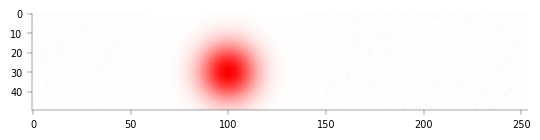

In [274]:
plt.imshow(temp_ft_initial.transpose(), cmap='bwr', vmin=240-20, vmax=240+20)

In [275]:
for i in tqdm(range(nt-1)):
    temp_ft[i+1, 1:-1, 1:-1] = fd_time(temp_ft[i], prefactor, dt, dx, dy)
    temp_ft[i+1] = set_boundary_conditions(temp_ft[i+1], periodic_x, periodic_y)

100%|██████████| 49999/49999 [00:08<00:00, 5695.39it/s]


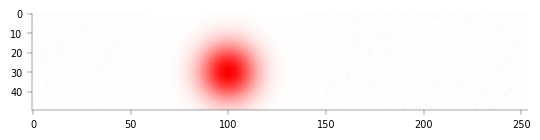

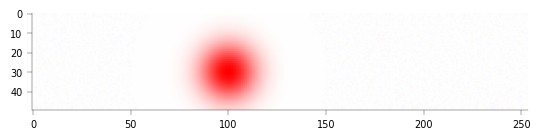

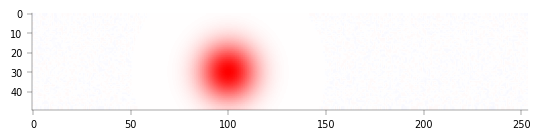

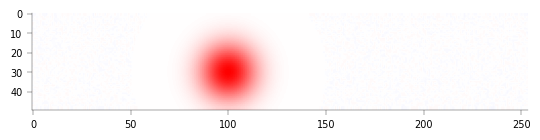

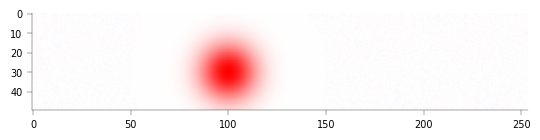

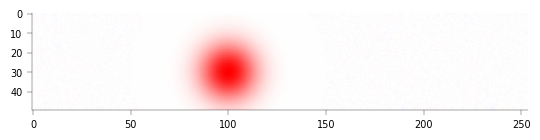

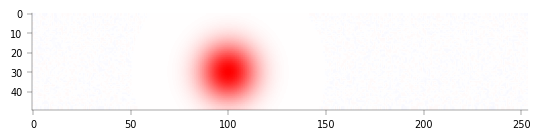

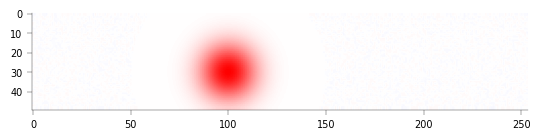

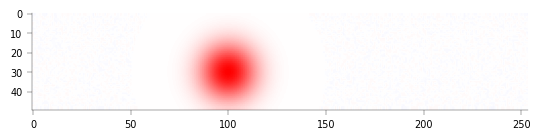

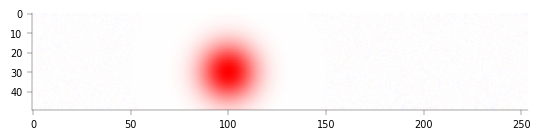

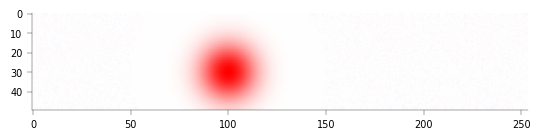

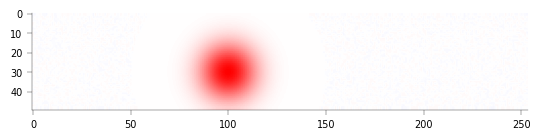

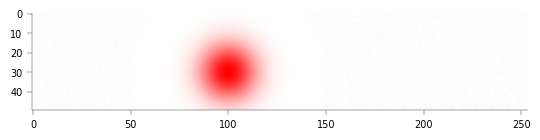

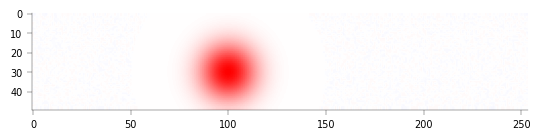

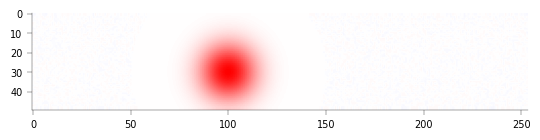

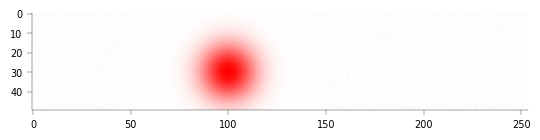

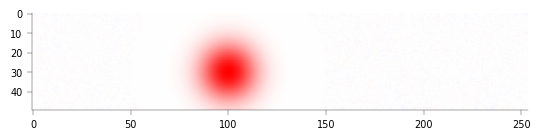

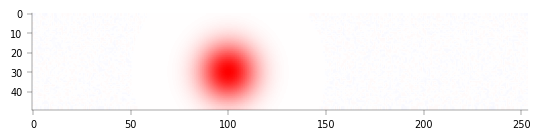

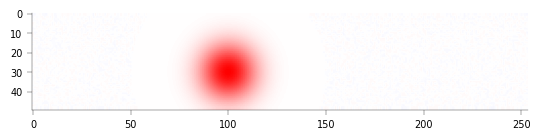

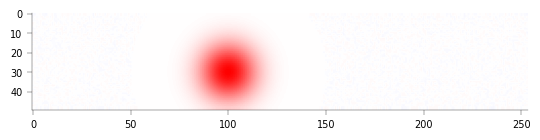

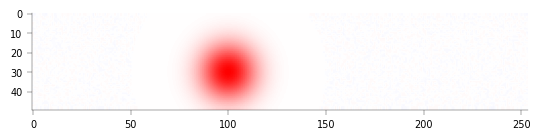

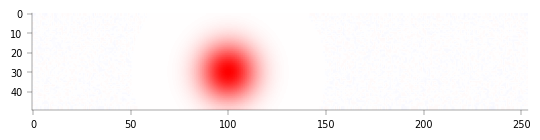

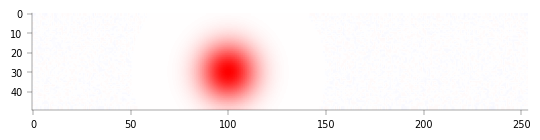

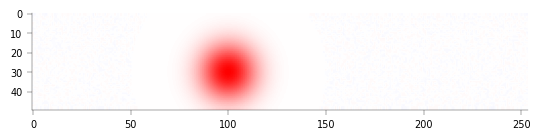

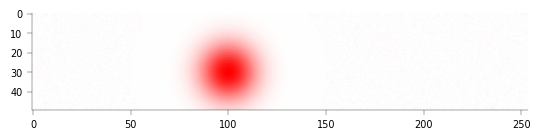

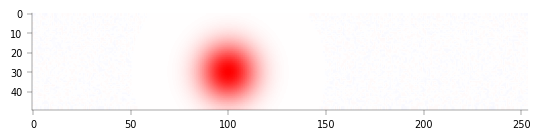

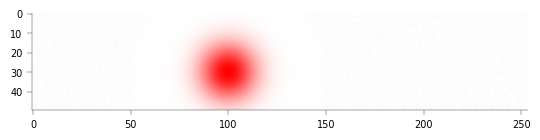

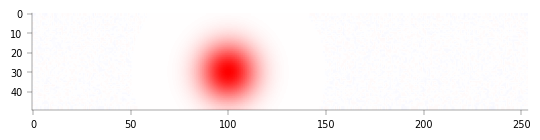

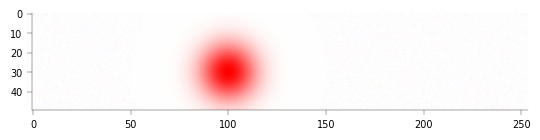

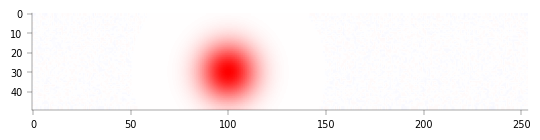

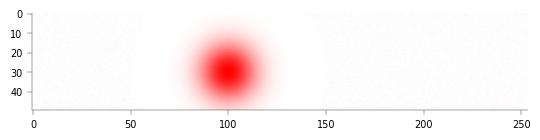

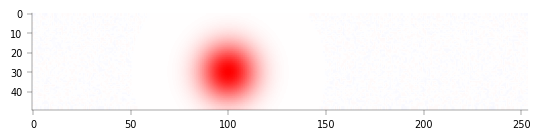

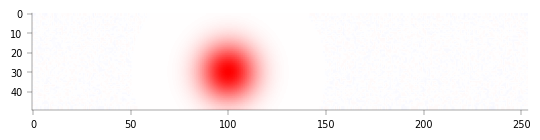

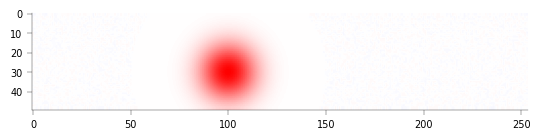

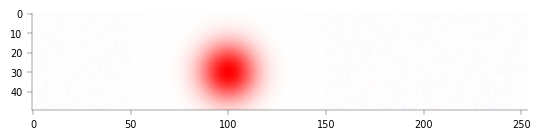

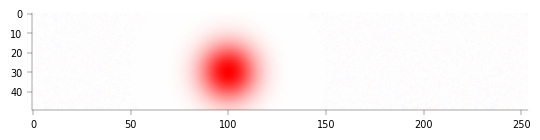

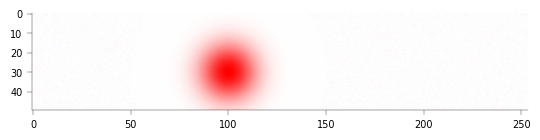

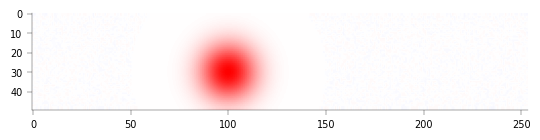

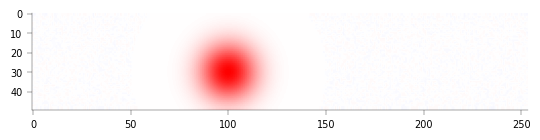

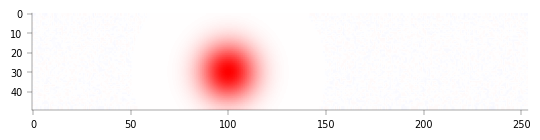

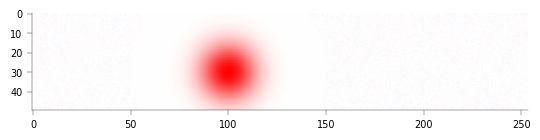

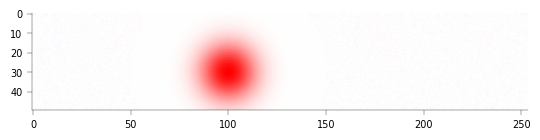

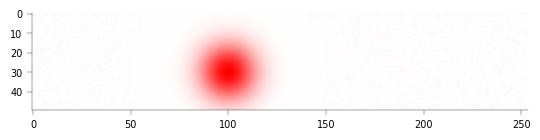

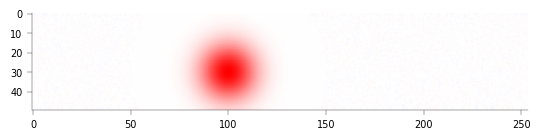

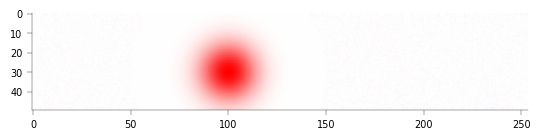

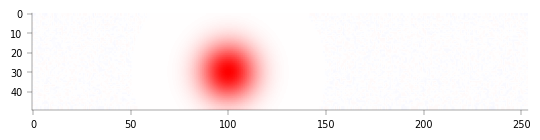

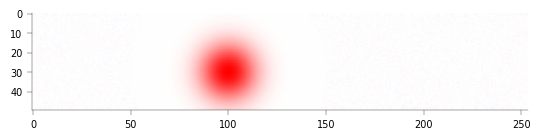

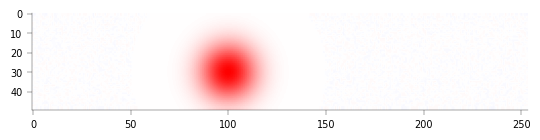

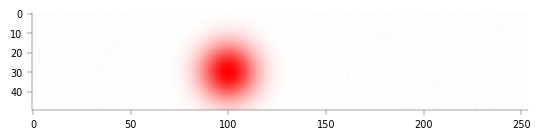

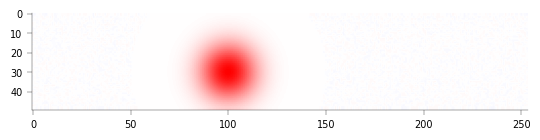

In [276]:
for i in range(0, nt, 1000):
    plt.imshow(temp_ft[i].transpose(), cmap='bwr', vmin=240-20, vmax=240+20)
    plt.show()

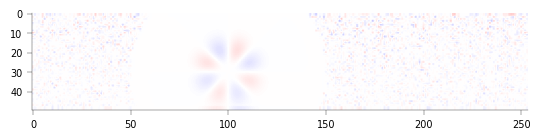

In [277]:
plt.imshow(temp_ft[-1].transpose() - temp_ft[0].transpose(), cmap='bwr', vmin=-0.5, vmax=0.5)

In [233]:
(temp_ft[1].transpose() - temp_ft[0].transpose() - (temp_ft[2].transpose() - temp_ft[1].transpose())).max()

1.5631940186722204e-12

In [221]:
(temp_ft[-1] - temp_ft[-2]).max()

1.8625663358307065e-06

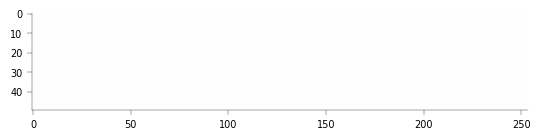

In [130]:
plt.imshow(temp_ft[-100].transpose() - temp_ft[0].transpose(), cmap='bwr', vmin=-5, vmax=5)

In [125]:
temp_ft[1].transpose() - temp_ft[0].transpose()

array([[ 4.39295647e-05, -2.21637212e-05,  9.03506645e-06, ...,
        -1.24766662e-05,  4.39295647e-05, -2.21637212e-05],
       [ 4.39295647e-05, -2.21637212e-05,  9.03506645e-06, ...,
        -1.24766662e-05,  4.39295647e-05, -2.21637212e-05],
       [-9.80118691e-05, -6.64588362e-06,  2.30367259e-05, ...,
        -1.39801249e-05, -9.80118691e-05, -6.64588362e-06],
       ...,
       [-3.86821187e-05, -1.18105234e-05, -3.00566856e-06, ...,
         2.09014476e-06, -3.86821187e-05, -1.18105234e-05],
       [ 3.25281165e-05, -4.88704245e-06, -3.68008970e-05, ...,
        -3.20932486e-07,  3.25281165e-05, -4.88704245e-06],
       [ 3.25281165e-05, -4.88704245e-06, -3.68008970e-05, ...,
        -3.20932486e-07,  3.25281165e-05, -4.88704245e-06]])